In [122]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import os
import seaborn as sns
from glob import glob 
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix, classification_report

In [123]:
#Import metadata 
df =pd.read_csv('HAM10000_metadata.csv')

In [124]:
df.head(25)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [125]:
path = "HAM10000_images/"

In [126]:
#Adding name of image to dataset
df["image_name"] = df['image_id']+ '.jpg'
X = df[["image_name",'dx', 'lesion_id']]

In [127]:
X.sample(5)

,image_name,dx,lesion_id
6061,ISIC_0026010.jpg,nv,HAM_0004916
9324,ISIC_0030410.jpg,nv,HAM_0006553
8770,ISIC_0032107.jpg,nv,HAM_0003313
328,ISIC_0027068.jpg,bkl,HAM_0007296
836,ISIC_0031987.jpg,bkl,HAM_0001781


In [128]:
#Splitting dataset
#Reference https://www.youtube.com/watch?v=nuakBf3rBmw
from sklearn.model_selection import train_test_split
y = X.pop('dx').to_frame()
X_train, X_test_, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=42)

In [129]:
train = pd.concat([X_train, y_train], axis=1)
val = pd.concat([X_val, y_val], axis=1)
test = pd.concat([X_train, y_train], axis=1)

In [130]:
train.head()

,image_name,lesion_id,dx
930,ISIC_0033480.jpg,HAM_0004788,bkl
1983,ISIC_0025524.jpg,HAM_0004642,mel
7485,ISIC_0032893.jpg,HAM_0005383,nv
1420,ISIC_0029343.jpg,HAM_0003330,mel
6292,ISIC_0031944.jpg,HAM_0004162,nv


In [131]:
encoder = LabelEncoder()
encoder.fit(val['dx'])
name_as_indexes_train = encoder.transform(val['dx'])
val['label'] = name_as_indexes_train

In [132]:
val.head()

,image_name,lesion_id,dx,label
6046,ISIC_0029761.jpg,HAM_0005948,nv,5
2660,ISIC_0033248.jpg,HAM_0002397,bcc,1
6979,ISIC_0028804.jpg,HAM_0006618,nv,5
887,ISIC_0028479.jpg,HAM_0002821,bkl,2
7631,ISIC_0033188.jpg,HAM_0001935,nv,5


In [133]:
encoder = LabelEncoder()
encoder.fit(test['dx'])
name_as_indexes_test = encoder.transform(test['dx'])
test['label'] = name_as_indexes_test

In [134]:
# train_generator = ImageDataGenerator(rescale = 1./255,
#                                      rotation_range = 10, 
#                                      zoom_range = 0.1,
#                                      width_shift_range=0.0, height_shift_range=0.00
# )
train_generator = ImageDataGenerator(rescale = 1./255)

In [135]:
train_data = train_generator.flow_from_dataframe(dataframe=train, x_col='image_name', y_col="dx", batch_size=32, directory=path, shuffle =True, class_mode="categorical", target_size=(224,224))
#train_generator.fit(X_train)

Found 6409 validated image filenames belonging to 7 classes.


In [136]:
train_data.image_shape

(224, 224, 3)

In [137]:
# test_generator = ImageDataGenerator(rescale = 1./255,
#                                      rotation_range = 10, 
#                                      zoom_range = 0.1,
#                                      width_shift_range=0.0, height_shift_range=0.02
# )
test_generator = ImageDataGenerator(rescale = 1./255)

In [138]:
test_data = test_generator.flow_from_dataframe(dataframe=train, x_col='image_name', y_col="dx", batch_size=1, directory=path, shuffle=False, class_mode=None, target_size=(224,224))

Found 6409 validated image filenames.


In [139]:
test_data.image_shape

(224, 224, 3)

In [140]:
val_data = test_generator.flow_from_dataframe(dataframe=val, x_col='image_name', y_col="dx", batch_size=64, directory=path, shuffle=False, class_mode="categorical", target_size=(224,224))

Found 1603 validated image filenames belonging to 7 classes.


In [141]:
val_data.image_shape

(224, 224, 3)

### Showcase some of the training images

In [142]:
def plot_images(img_array):
    fig, axes = plt.subplots(1,5, figsize=(25,25))
    axes = axes.flatten()
    for img, ax in zip(img_array,axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

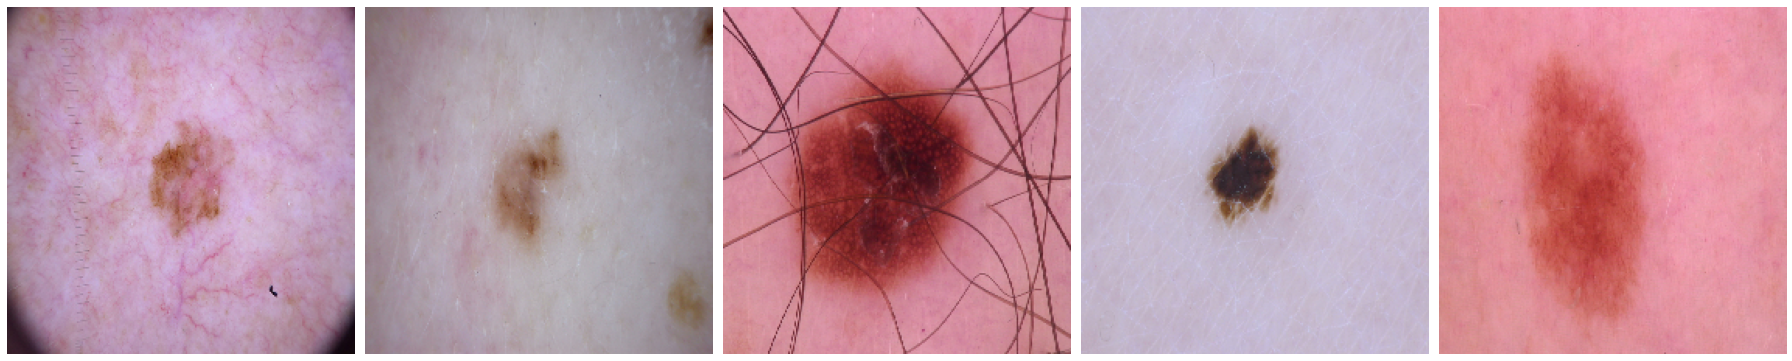

In [143]:
sample_train_images, _ = next(train_data)
plot_images(sample_train_images[:5])

In [155]:
#Using model
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))
# for layer in model.layers:
#     layer.trainable = False

In [158]:
model = Sequential()
model.add(base_model)
model.add(Conv2D(16,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.40))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
#model.add(Dropout(0.4))
#Output layer must match the different outputs from our labels, in this case 7
model.add(Dense(7,activation='sigmoid'))

In [146]:
#learning_control = ReduceLROnPlateau(monitor='val_acc',patience=3, verbose=1, factor=.5, min_lr=0.0001)

In [161]:
sgd = SGD(learning_rate=0.01,clipvalue=0.5)
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])

In [162]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_6 (Conv2D)           (None, 5, 5, 16)          184336    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 2, 2, 16)         0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 128)               8320      
                                                                 
 dense_13 (Dense)            (None, 7)                

In [163]:
history=model.fit(train_data,batch_size=128, epochs=5, validation_data=val_data)

Epoch 1/5
201/201 [==============================] - 884s 4s/step - loss: 0.8952 - accuracy: 0.6906 - val_loss: 2.1701 - val_accuracy: 0.6606
Epoch 2/5
201/201 [==============================] - 819s 4s/step - loss: 0.6139 - accuracy: 0.7699 - val_loss: 2.7711 - val_accuracy: 0.6606
Epoch 3/5
201/201 [==============================] - 672s 3s/step - loss: 0.4692 - accuracy: 0.8224 - val_loss: 2.8083 - val_accuracy: 0.6650
Epoch 4/5
201/201 [==============================] - 658s 3s/step - loss: 0.3423 - accuracy: 0.8719 - val_loss: 2.1622 - val_accuracy: 0.6725
Epoch 5/5
201/201 [==============================] - 661s 3s/step - loss: 0.2567 - accuracy: 0.9062 - val_loss: 2.8302 - val_accuracy: 0.6787


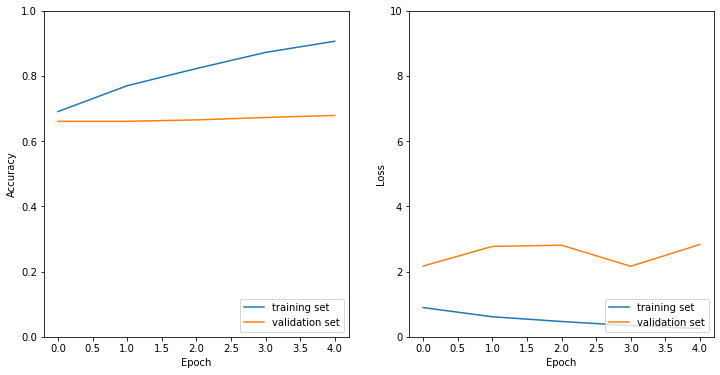

In [166]:
import tensorflow

def plot_history(history):
    """ This helper function takes the tensorflow.python.keras.callbacks.History
    that is output from your `fit` method to plot the loss and accuracy of
    the training and validation set.
    """
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].plot(history.history['accuracy'], label='training set')
    axs[0].plot(history.history['val_accuracy'], label = 'validation set')
    axs[0].set(xlabel = 'Epoch', ylabel='Accuracy', ylim=[0, 1])

    axs[1].plot(history.history['loss'], label='training set')
    axs[1].plot(history.history['val_loss'], label = 'validation set')
    axs[1].set(xlabel = 'Epoch', ylabel='Loss', ylim=[0, 10])
    
    axs[0].legend(loc='lower right')
    axs[1].legend(loc='lower right')
    
plot_history(history)

In [168]:
# score =model.evaluate(test_data)
# print('Test accuracy: ', score)

6409/6409 [==============================] - 88s 14ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Test accuracy:  [0.0, 0.0]


In [169]:
history.history

{'loss': [0.8951676487922668,
  0.6139388680458069,
  0.469226211309433,
  0.34229543805122375,
  0.2566726803779602],
 'accuracy': [0.6905913352966309,
  0.7698549032211304,
  0.8224372267723083,
  0.871898889541626,
  0.9062256217002869],
 'val_loss': [2.170067310333252,
  2.7710628509521484,
  2.808253288269043,
  2.16218638420105,
  2.8302369117736816],
 'val_accuracy': [0.660636305809021,
  0.660636305809021,
  0.6650031208992004,
  0.6724891066551208,
  0.678727388381958]}

In [173]:
model.save('./model/my_model.h5')